# importing libraries

In [34]:
import pandas as pd
import seaborn as sns

from wordcloud import WordCloud #Word visualization
import matplotlib.pyplot as plt #Plotting properties
import seaborn as sns #Plotting properties
from sklearn.feature_extraction.text import CountVectorizer #Data transformation
from sklearn.model_selection import train_test_split #Data testing
from sklearn.linear_model import LogisticRegression #Prediction Model
from sklearn.metrics import accuracy_score #Comparison between real and predicted
#from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder #Variable encoding and decoding for XGBoost
import re #Regular expressions
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from string import punctuation
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# reading and making data frame

In [35]:
train_df = pd.read_csv('twitter_training.csv')
train_df.columns=['id','information','sentiment','text']
train_df.head()

,id,information,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [36]:
val_df = pd.read_csv('twitter_validation.csv')
val_df.columns=['id','information','sentiment','text']
val_df.head()

,id,information,sentiment,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


# EDA

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           74681 non-null  int64 
 1   information  74681 non-null  object
 2   sentiment    74681 non-null  object
 3   text         73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [38]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           999 non-null    int64 
 1   information  999 non-null    object
 2   sentiment    999 non-null    object
 3   text         999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [39]:
unique_categories_train = train_df['sentiment'].unique()
print("Unique categories:", unique_categories_train)

Unique categories: ['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [40]:
unique_categories_val = val_df['sentiment'].unique()
print("Unique categories:", unique_categories_val)

Unique categories: ['Neutral' 'Negative' 'Positive' 'Irrelevant']


# preprocessing

In [41]:
#dropping unnecessary columns
train_df = train_df[train_df['sentiment'] != 'Irrelevant']
val_df = val_df[val_df['sentiment'] != 'Irrelevant']

In [42]:
train_df= train_df[['text', 'sentiment']]
val_df= val_df[['text', 'sentiment']]

In [43]:
train_df.head()

,text,sentiment
0,I am coming to the borders and I will kill you...,Positive
1,im getting on borderlands and i will kill you ...,Positive
2,im coming on borderlands and i will murder you...,Positive
3,im getting on borderlands 2 and i will murder ...,Positive
4,im getting into borderlands and i can murder y...,Positive


In [44]:
val_df.head()

,text,sentiment
0,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral
1,@Microsoft Why do I pay for WORD when it funct...,Negative
2,"CSGO matchmaking is so full of closet hacking,...",Negative
3,Now the President is slapping Americans in the...,Neutral
4,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Negative


In [45]:
label_encoder = LabelEncoder()

# Fit and transform the 'sentiment' column
train_df['sentiment'] = label_encoder.fit_transform(train_df['sentiment'])
val_df['sentiment'] = label_encoder.fit_transform(val_df['sentiment'])

In [46]:
# Convert the 'text' column to string, replacing NaNs with empty strings
train_df['text'] = train_df['text'].fillna('').astype(str)

# Initialize SnowballStemmer and a list of words to be removed
lem = SnowballStemmer("english")
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)

# Process the text data
final_corpus = []
final_corpus_joined = []
for i in train_df.index:
    text = re.sub('[^a-zA-Z]', ' ', train_df['text'][i])
    text = text.lower()
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    text = re.sub("(\\d|\\W)+", " ", text)
    text = text.split()
    text = [lem.stem(word) for word in text if word not in stuff_to_be_removed] 
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

In [48]:
data_cleaned = pd.DataFrame()
data_cleaned["text"] = final_corpus_joined
data_cleaned["sentiment"] = train_df["sentiment"].values

In [49]:
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = train_df['sentiment'].values
data_eda.head()

,text,sentiment
0,"[come, border, kill]",2
1,"[im, get, borderland, kill]",2
2,"[im, come, borderland, murder]",2
3,"[im, get, borderland, murder]",2
4,"[im, get, borderland, murder]",2


# WordCloud and plotting

In [50]:
positive = data_eda[data_eda['sentiment'] == 2]
positive_list = positive['text'].tolist()
negative = data_eda[data_eda['sentiment'] == 0]
negative_list = negative['text'].tolist()
neutral = data_eda[data_eda['sentiment'] == 1]
neutral_list = neutral['text'].tolist()

In [51]:
positive_all = " ".join([word for sent in positive_list for word in sent ])
negative_all = " ".join([word for sent in negative_list for word in sent ])
neutral_all = " ".join([word for sent in neutral_list for word in sent ])

 Positive = 2

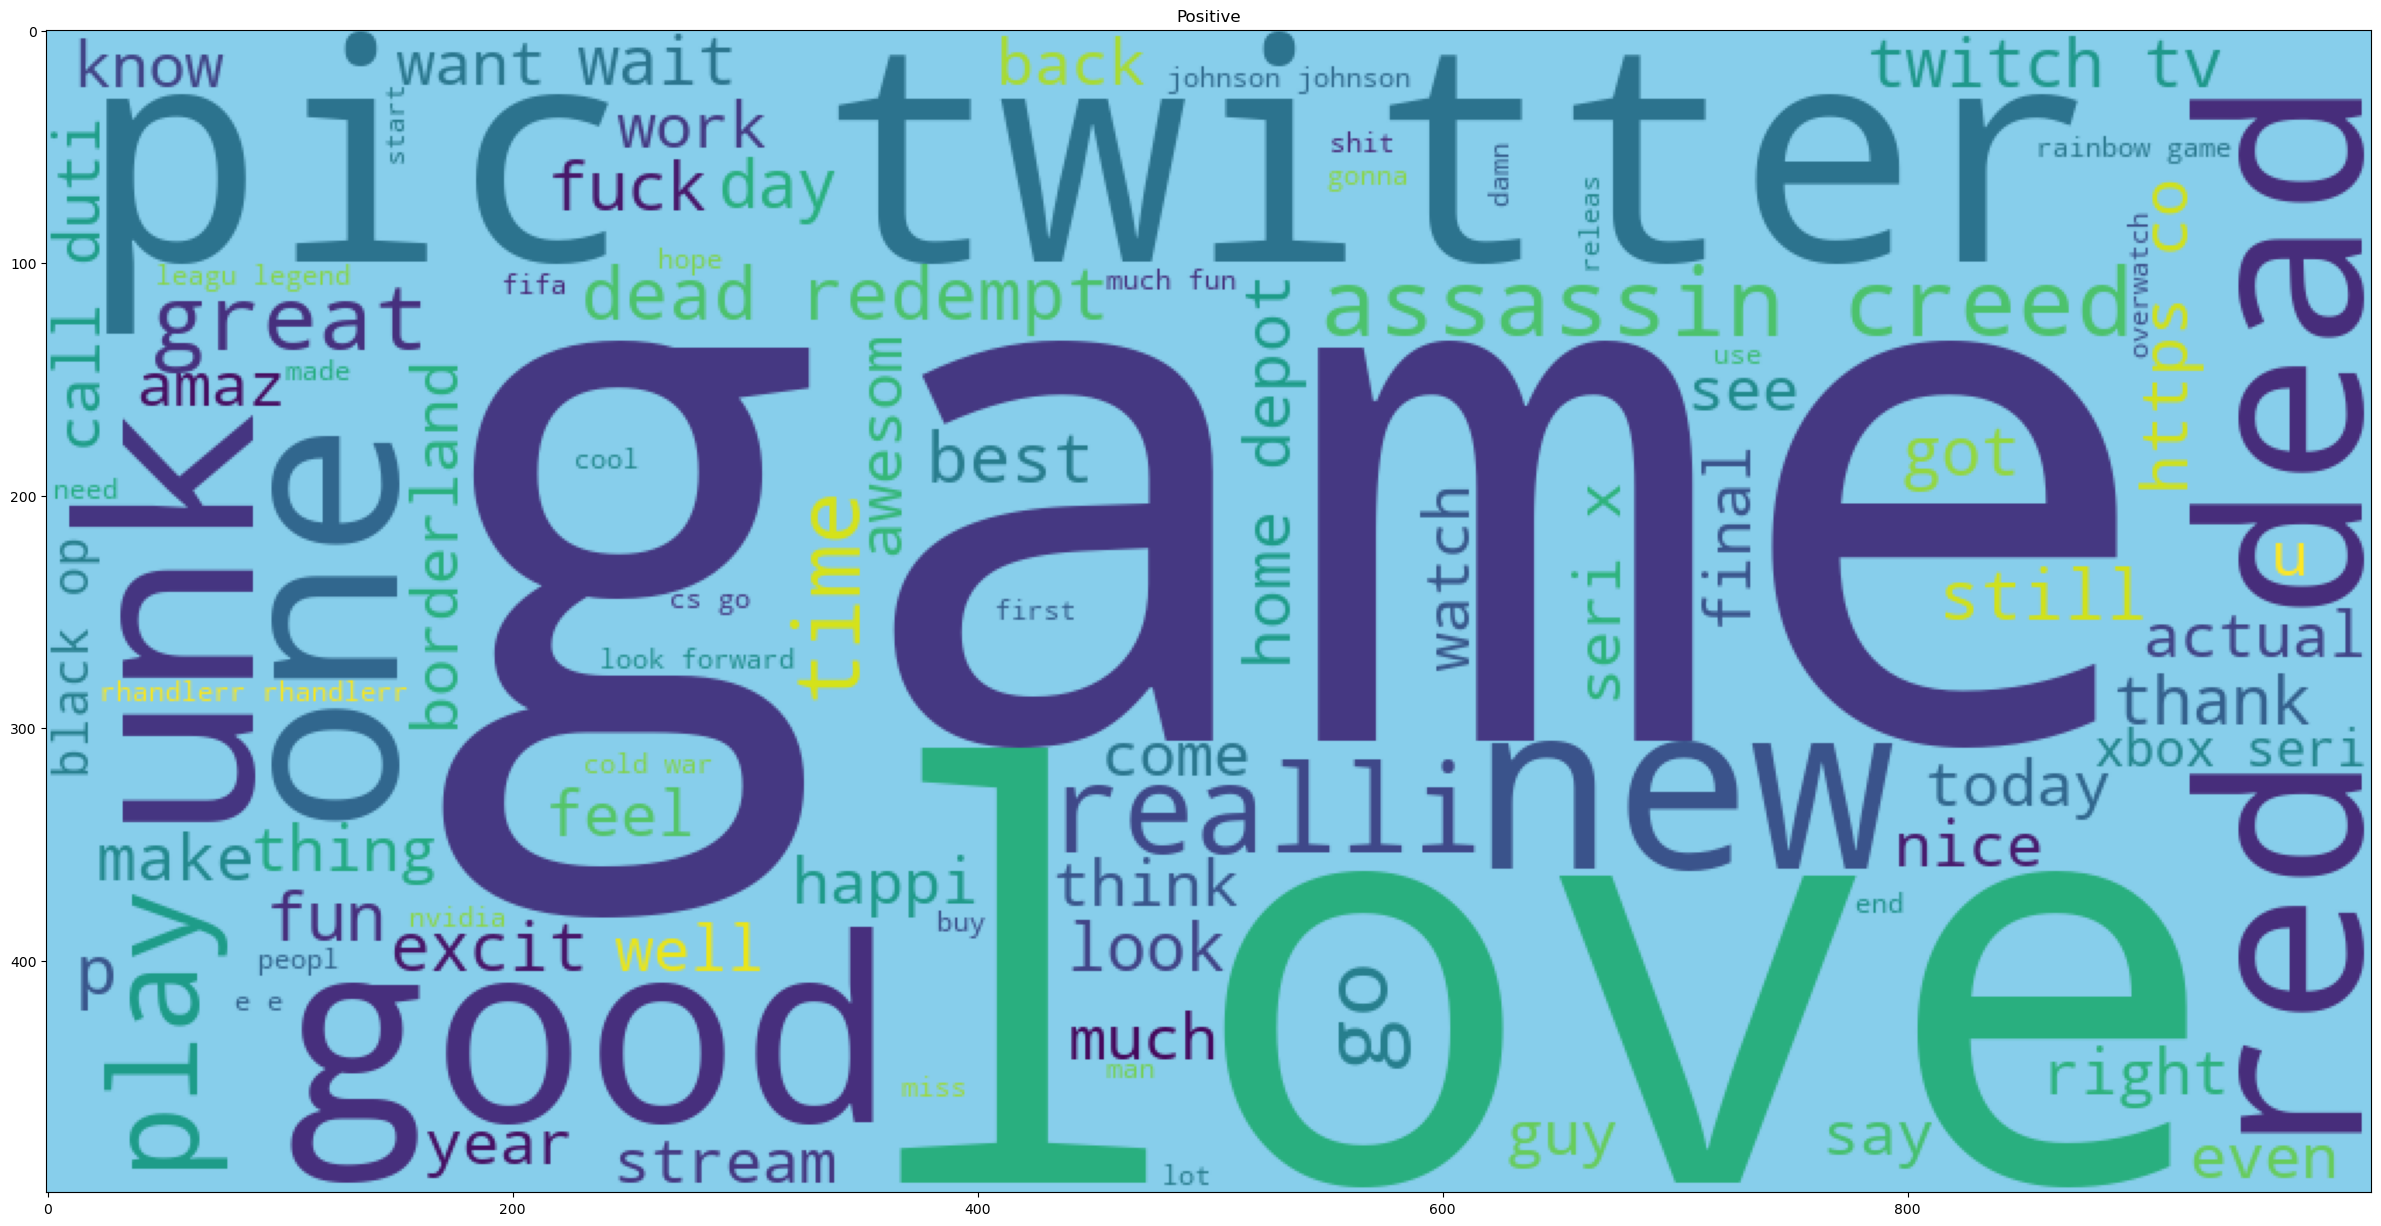

In [52]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=1000,
                      height=500,
                      background_color='skyblue',
                      max_words = 90).generate(positive_all)

plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

negative = 0

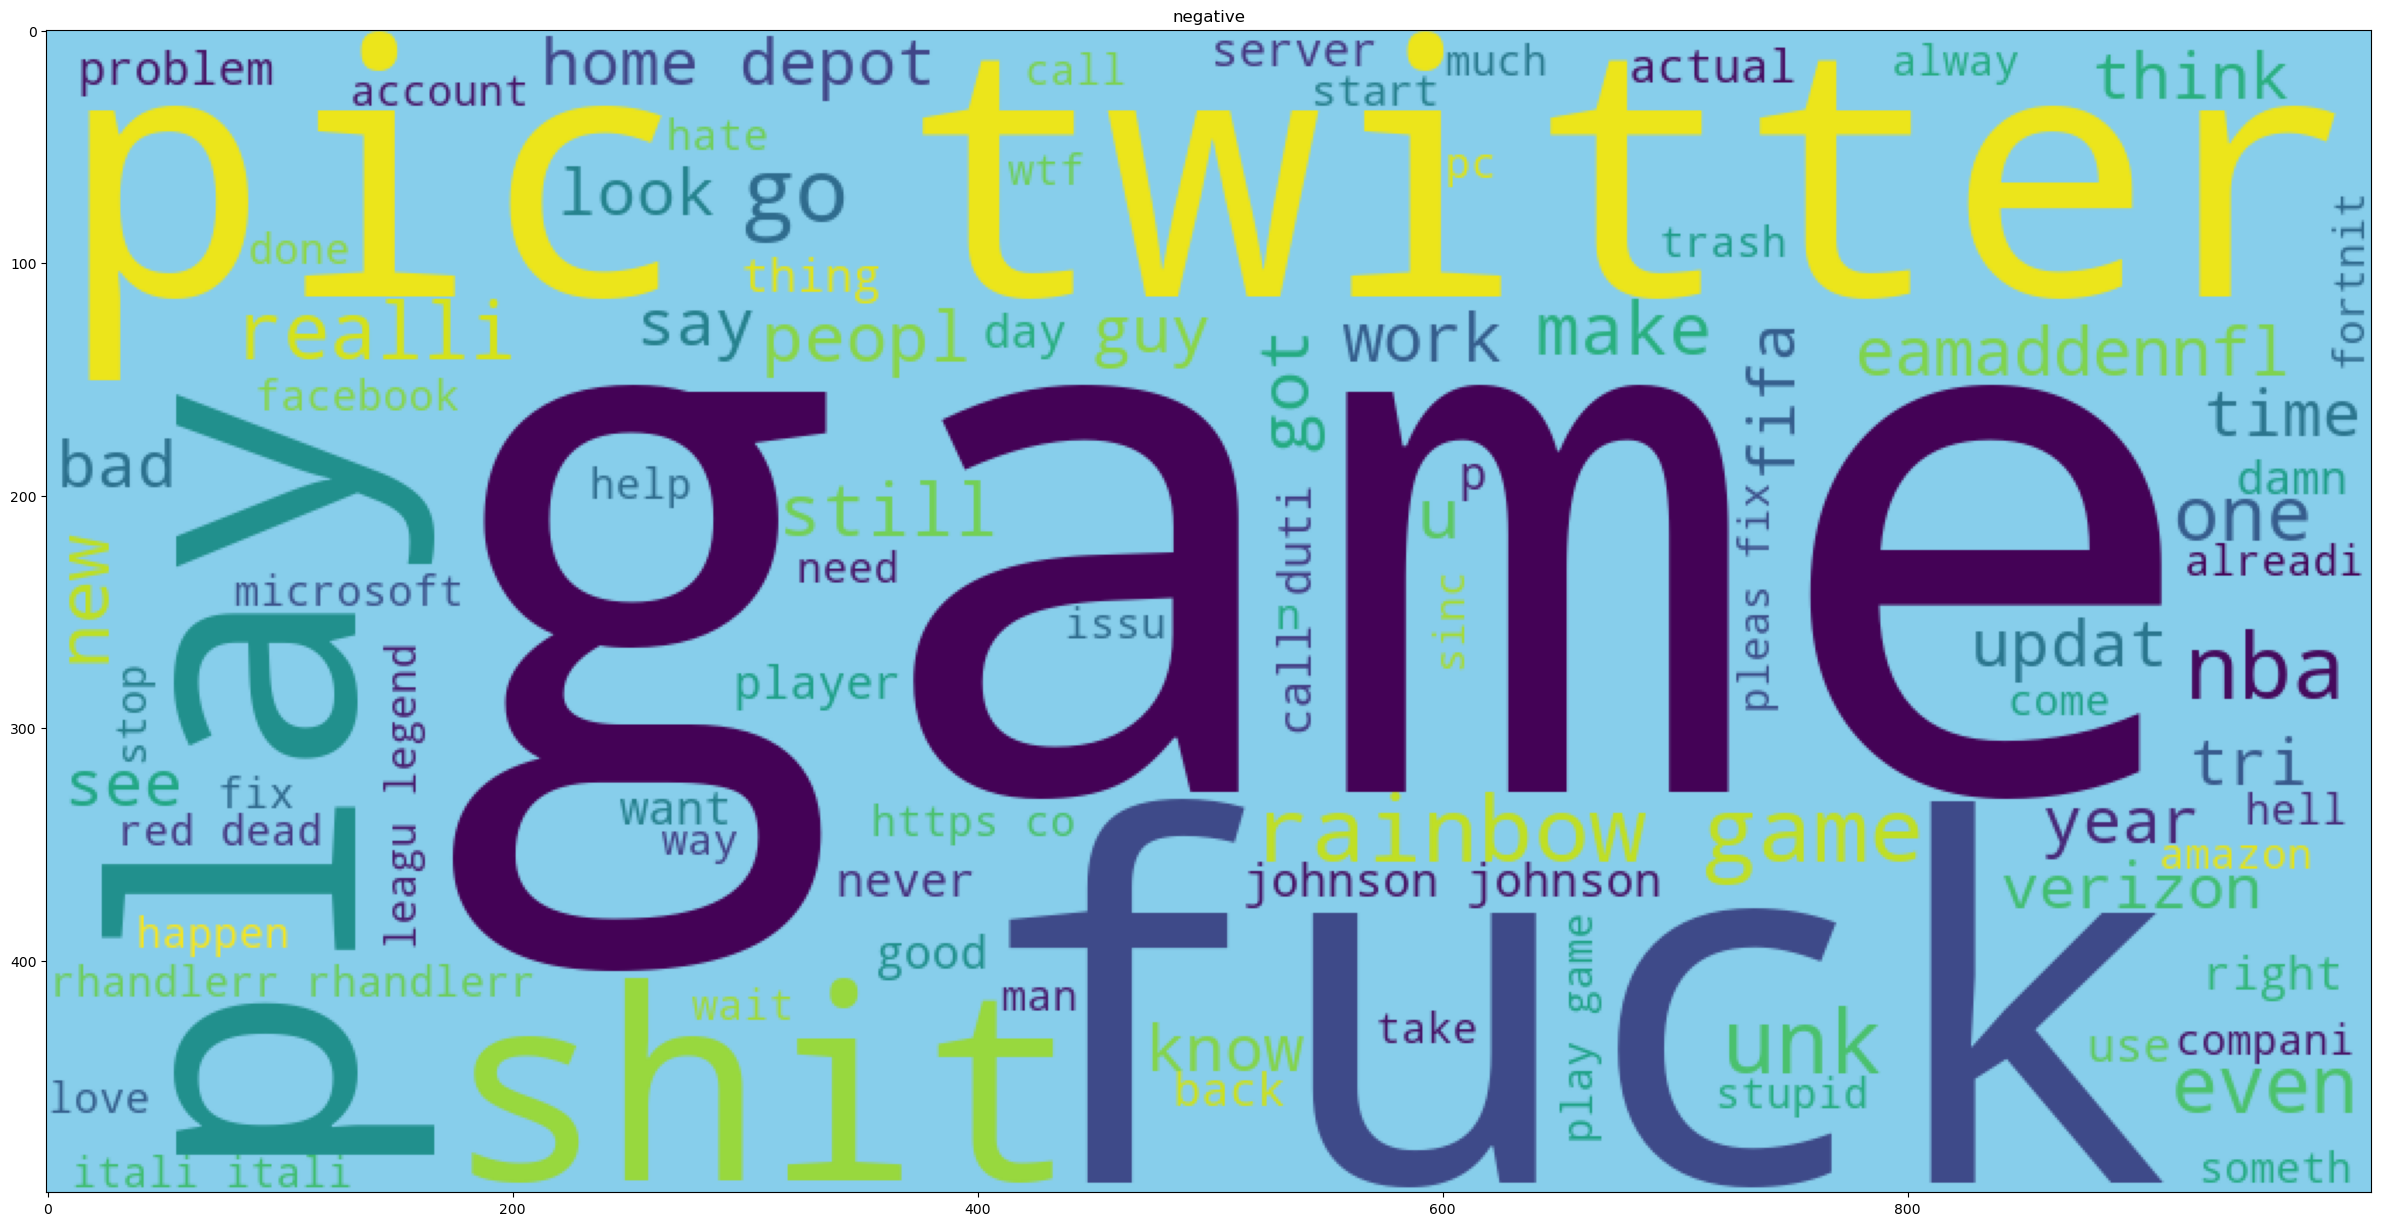

In [53]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=1000,
                      height=500,
                      background_color='skyblue',
                      max_words = 90).generate(negative_all)

plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.title("negative")
plt.show()

neutral = 1

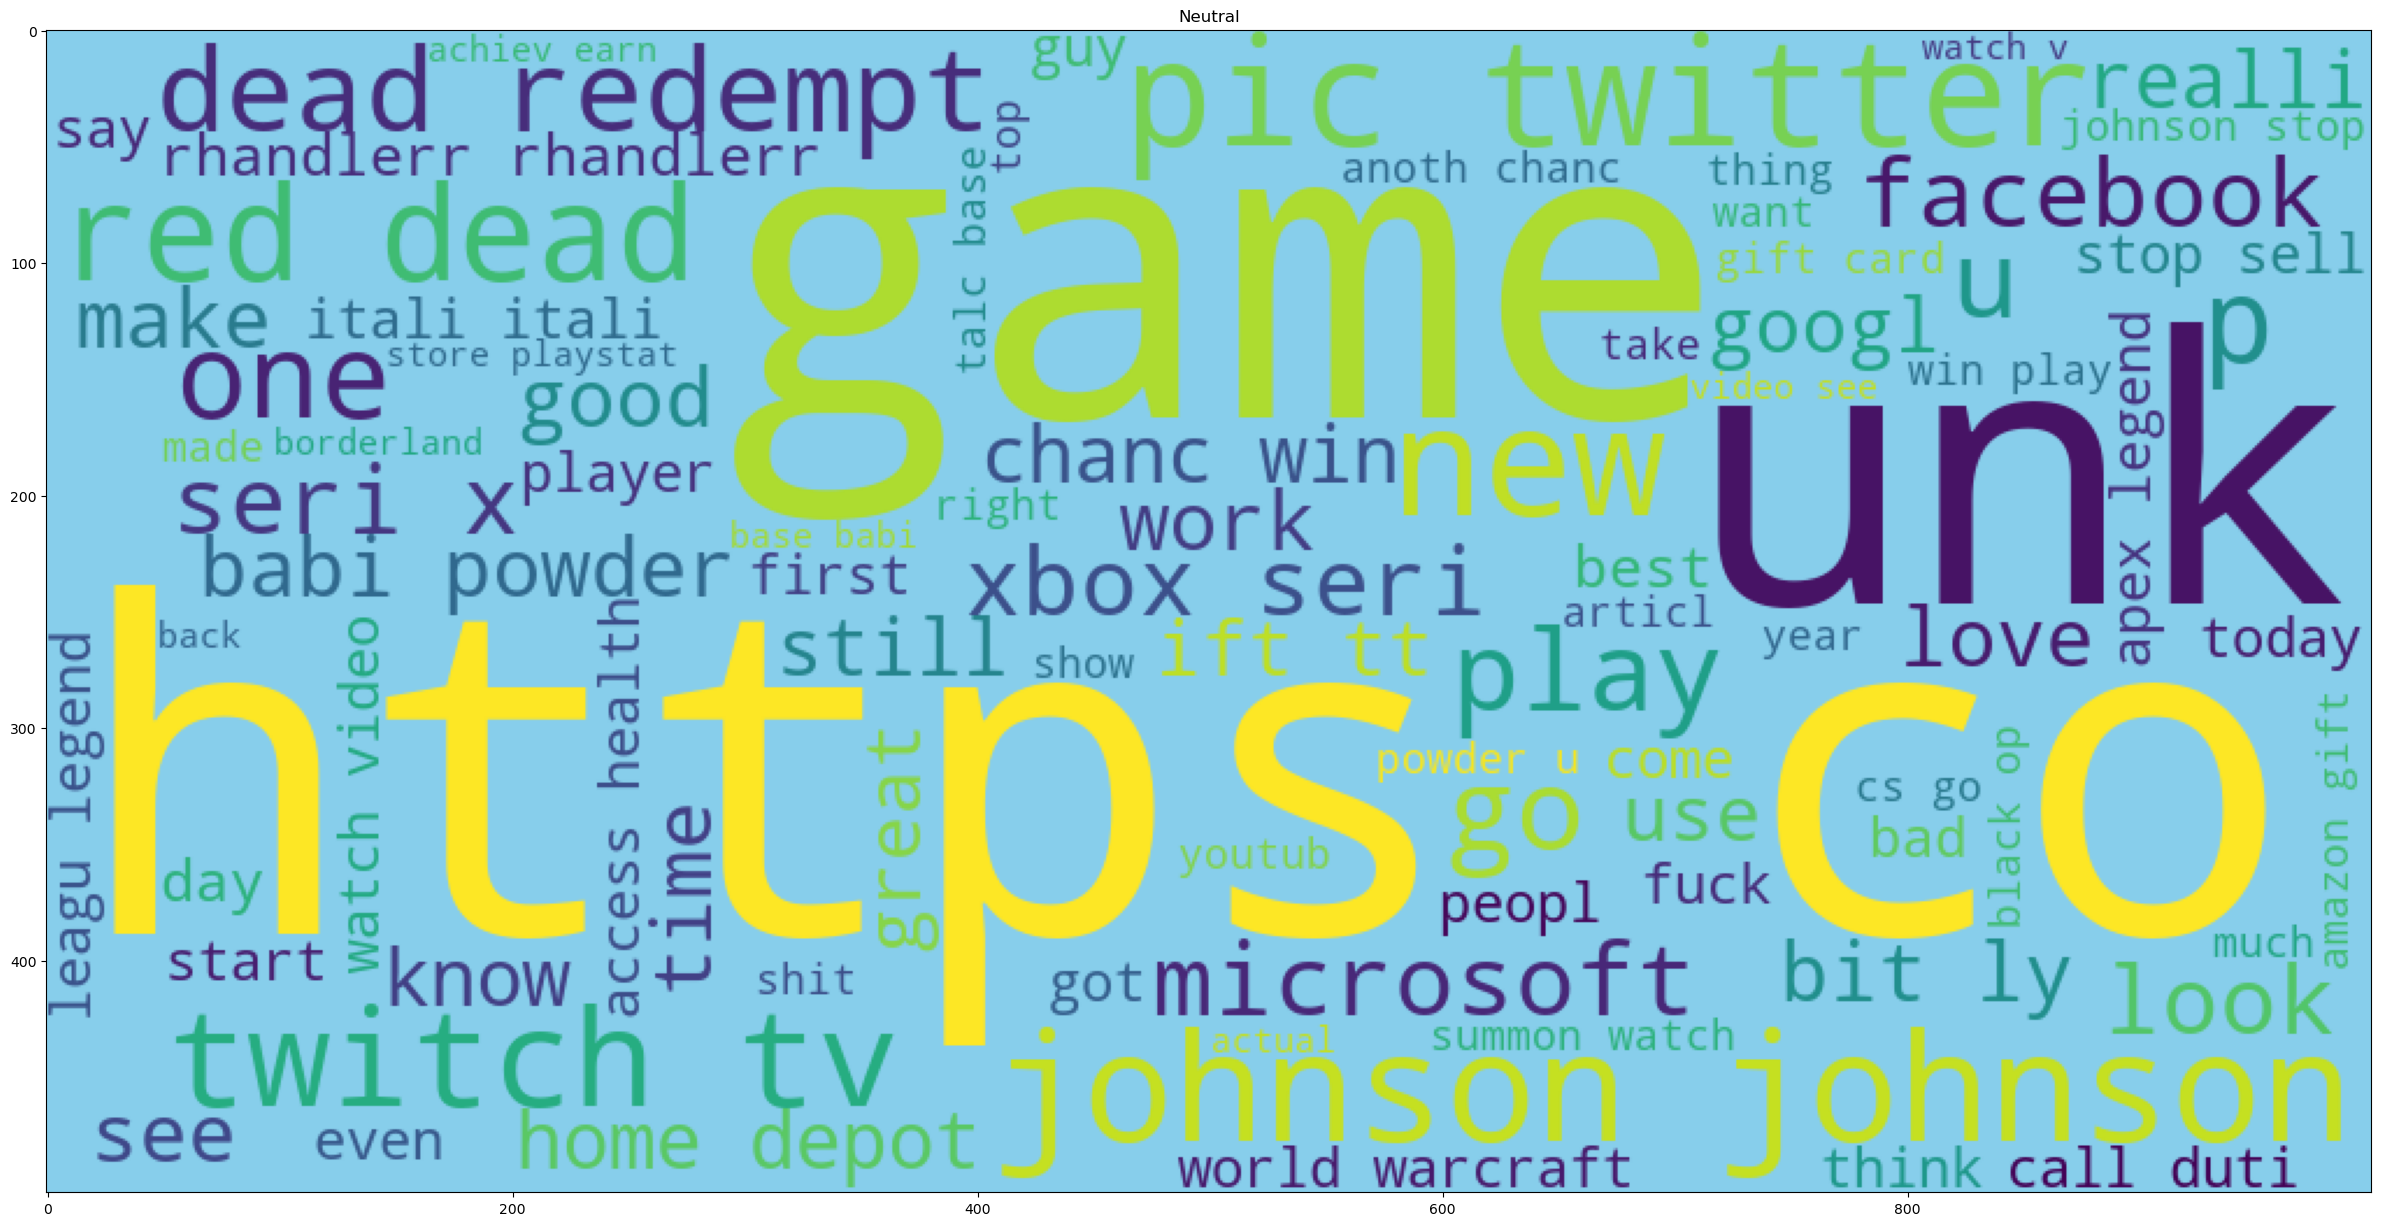

In [54]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=1000,
                      height=500,
                      background_color='skyblue',
                      max_words = 90).generate(neutral_all)

plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.title("Neutral")
plt.show()

<Axes: xlabel='sentiment', ylabel='Count'>

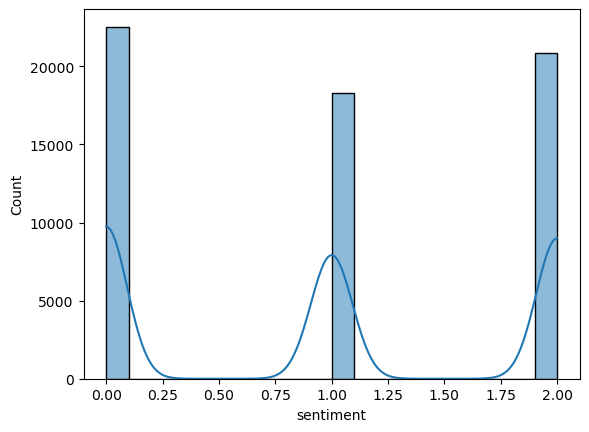

In [55]:
sns.histplot(train_df['sentiment'], kde=True)

# model preparation

In [56]:
X = data_cleaned['text']
y = data_cleaned['sentiment']

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer()
Xt = tfid.fit_transform(X)

In [58]:
# Save the TfidfVectorizer and the transformed data
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfid, file)

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state= 42)

In [62]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\Alika\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [63]:
y_pred = model.predict(X_test)
print(y_pred)


[1 0 2 ... 0 1 0]


In [64]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print('Classification Report:\n', classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      4492
           1       0.84      0.73      0.78      3678
           2       0.78      0.85      0.81      4169

    accuracy                           0.81     12339
   macro avg       0.81      0.81      0.81     12339
weighted avg       0.81      0.81      0.81     12339



# export model

In [65]:
import pickle

In [66]:
with open('model_logreg.pkl', 'wb') as file:
    pickle.dump(model, file)

# Load the model from the file
with open('model_logreg.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [67]:
accuracy = loaded_model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 81.02%
